# Package

In [1]:
import numpy  as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor

import os
from tqdm import tqdm
from glob import glob # read and close image in folder

# get VOC dataset
from torchvision.datasets import VOCSegmentation

/home/lexuanthang/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="Data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask 

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        
        # vì mask nhận vào chỉ nhận các giá trị 0,1,2,3,...,20 tương ứng với các class nen
        mask = mask.argmax(dim=2)
        
        return image, mask

In [3]:
trainsize = 257
train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
#     A.Cutout(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

In [4]:
def tensor_to_np(tensor):
    # Make sure the tensor is on the CPU and convert to NumPy
    return tensor.detach().cpu().numpy()

def np_to_tensor(array):
    # Convert a NumPy array back to PyTorch tensor
    return torch.tensor(array).float()

def inverse_norm(image):
    # Define the inverse transformation using Albumentations
    invTrans = A.Compose([
        A.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225], max_pixel_value=1.0),
        A.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.], max_pixel_value=1.0),
    ])

    # Example usage:
    # Assuming 'tensor_image' is your normalized image tensor
    tensor_image_np = tensor_to_np(image)  # Convert tensor to numpy array
    tensor_image_np = np.transpose(tensor_image_np, (1, 2, 0))  # CHW to HWC for Albumentations

    # Apply the inverse transformation
    inv_img_np = invTrans(image=tensor_image_np)['image']
    inv_img_np = np.transpose(inv_img_np, (2, 0, 1))  # HWC back to CHW for PyTorch

    # Convert back to tensor
    inv_img_tensor = np_to_tensor(inv_img_np)
    return inv_img_tensor


In [5]:
train_dataset_full = PascalVOCSearchDataset(image_set="train", download=False, transform=train_transform)
test_dataset_full = PascalVOCSearchDataset(image_set="val", download=False, transform=test_transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


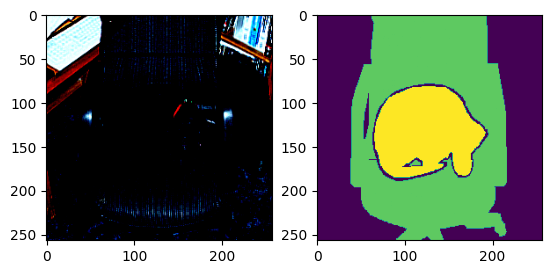

In [6]:
from torch.utils.data import Subset
import random
# Generate random, non-repeating indices for the subsets
random.seed(42)  # for reproducibility
train_indices = random.sample(range(len(train_dataset_full)), 100)
test_indices = random.sample(range(len(test_dataset_full)), 100)

# Create subsets
train_dataset = Subset(train_dataset_full, train_indices)
test_dataset = Subset(test_dataset_full, test_indices)

im, mk = train_dataset.dataset.__getitem__(2)

plt.subplot(1,2,1)
plt.imshow(im.permute(1,2, 0))
plt.subplot(1,2,2)
plt.imshow(mk)
plt.show()

# Model

[Model from paper](https://drive.google.com/drive/folders/1Hrz1wOxOZm4nIIS7UMJeL79AQrdvpj6v)

## ResNet 50

In [7]:
# get pretrained model , get res50 model
# !wget -O Models/resnet50_v2.pth  "https://drive.google.com/uc?export=download&id=1w5pRmLJXvmQQA5PtCbHhZc_uC4o0YbmA" 

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
    
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, deep_base=True):
        super(ResNet, self).__init__()
        self.deep_base = deep_base
        if not self.deep_base:
            self.inplanes = 64
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
        else:
            self.inplanes = 128
            self.conv1 = conv3x3(3, 64, stride=2)
            self.bn1 = nn.BatchNorm2d(64)
            self.conv2 = conv3x3(64, 64)
            self.bn2 = nn.BatchNorm2d(64)
            self.conv3 = conv3x3(64, 128)
            self.bn3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        if self.deep_base:
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [9]:
def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        # model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
        model_path = 'Models/resnet50_v2.pth'
        model.load_state_dict(torch.load(model_path), strict=False)
    return model


## PSPNET

In [10]:

class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)
    
class PSPNet(nn.Module):
    def __init__(self, layers=50, bins=(1, 2, 3, 6), dropout=0.1, classes=2, zoom_factor=8, use_ppm=True, criterion=nn.CrossEntropyLoss(ignore_index=255), pretrained=True):
        super(PSPNet, self).__init__()
        assert layers in [50, 101, 152]
        assert 2048 % len(bins) == 0
        assert classes > 1
        assert zoom_factor in [1, 2, 4, 8]
        self.zoom_factor = zoom_factor
        self.use_ppm = use_ppm
        self.criterion = criterion

        if layers == 50:
            resnet = resnet50(pretrained=pretrained)
        # elif layers == 101:
        #     resnet = resnet101(pretrained=pretrained)
        # else:
        #     resnet = resnet152(pretrained=pretrained)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.conv2, resnet.bn2, resnet.relu, resnet.conv3, resnet.bn3, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)

        fea_dim = 2048
        if use_ppm:
            self.ppm = PPM(fea_dim, int(fea_dim/len(bins)), bins)
            fea_dim *= 2
        self.cls = nn.Sequential(
            nn.Conv2d(fea_dim, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(512, classes, kernel_size=1)
        )
        if self.training:
            self.aux = nn.Sequential(
                nn.Conv2d(1024, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(256, classes, kernel_size=1)
            )

    def forward(self, x, y=None):
        x_size = x.size()
        assert (x_size[2]-1) % 8 == 0 and (x_size[3]-1) % 8 == 0
        h = int((x_size[2] - 1) / 8 * self.zoom_factor + 1)
        w = int((x_size[3] - 1) / 8 * self.zoom_factor + 1)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_tmp = self.layer3(x)
        x = self.layer4(x_tmp)
        if self.use_ppm:
            x = self.ppm(x)
        x = self.cls(x)
        if self.zoom_factor != 1:
            x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)

        if self.training:
            aux = self.aux(x_tmp)
            if self.zoom_factor != 1:
                aux = F.interpolate(aux, size=(h, w), mode='bilinear', align_corners=True)
            main_loss = self.criterion(x, y)
            aux_loss = self.criterion(aux, y)
            return x.max(1)[1], main_loss, aux_loss
        else:
            return x

In [11]:
# image_size = 257
# model = PSPNet()
# x = torch.rand(4,3,image_size, image_size).float()
# y = torch.ones(4,image_size,image_size).long()
# a1, a2, a3 = model(x, y)
# print(a1.shape, a2, a3)

## Metrics

In [12]:
class AverageMetric(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val=0
        self.avg=0
        self.sum=0
        self.count=0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count


def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

In [15]:

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8

n_workers = 4
print("number of workers=", n_workers)
print(device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = n_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = n_workers)

#model
model = PSPNet(classes=21)
# model= nn.DataParallel(model)
model.to(device)

#loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20

#metrics
dice_fn = torchmetrics.Dice(num_classes=21, average="macro").to(device)
# iou_fn = intersectionAndUnionGPU().to(device)
acc_fn = torchmetrics.Accuracy(num_classes=21, task="multiclass").to(device)

# metric
acc_metric = AverageMetric()
dice_metric = AverageMetric()
intersection_metric = AverageMetric()
union_metric = AverageMetric()
target_metric = AverageMetric()
train_loss_metric = AverageMetric()

number of workers= 4
cuda


# Training

In [16]:
for epoch in range(num_epochs):
    acc_metric.reset()
    # dice_metric.reset()
    intersection_metric.reset()
    union_metric.reset()
    target_metric.reset()
    train_loss_metric.reset()

    model.train()
    for batch_id, (x, y) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        n = x.shape[0]
        
        x = x.to(device).float()
        y = y.to(device).long()

        yhat_mask, main_loss, ax_loss = model(x,y) # B,C,H,W 

        loss = main_loss + 0.4*ax_loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # yhat_mask = yhat.argmax(dim=1).squeeze() # B,C,H,W -> # B,1,H,W -> # B,H,W
            # print(yhat_mask.shape, y.shape)
            # dice_score = dice_fn(yhat_mask,y.long())
            # iou_score = iou_fn(yhat_mask, y.long())
            intersection, union, target = intersectionAndUnionGPU(yhat_mask.float(), y.float(),21)
            accuracy = acc_fn(yhat_mask, y.long())

            acc_metric.update(accuracy.item(), n)
            # dice_metric.update(dice_score.item(), n)
            intersection_metric.update(intersection)
            union_metric.update(union)
            target_metric.update(target)
            train_loss_metric.update(loss.item(), n)
            
    with torch.no_grad():
        iou_class = intersection_metric.sum / (union_metric.sum + 1e-10)
        dice_class = (2 * intersection_metric.sum) / (intersection_metric.sum + union_metric.sum + 1e-10)
        
        mIoU = torch.mean(iou_class)
        mDice = torch.mean(dice_class)

    print("Epoch {}: train_loss = {}, accuracy = {}, mIoU = {}, mDice = {}".format(
        epoch, train_loss_metric.avg, acc_metric.avg, mIoU, mDice
    ))

100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 0: train_loss = 3.4184564685821535, accuracy = 0.48578661799430845, mIoU = 0.09276404231786728, mDice = 0.14843052625656128


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 1: train_loss = 2.2064394092559816, accuracy = 0.7899124908447266, mIoU = 0.3706558644771576, mDice = 0.5195358991622925


100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


Epoch 2: train_loss = 1.629863543510437, accuracy = 0.8533879446983338, mIoU = 0.4884724020957947, mDice = 0.6368087530136108


100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch 3: train_loss = 1.3396002388000487, accuracy = 0.8800010585784912, mIoU = 0.5768815279006958, mDice = 0.7250331044197083


100%|██████████| 13/13 [00:22<00:00,  1.69s/it]


Epoch 4: train_loss = 1.1127449417114257, accuracy = 0.8972066140174866, mIoU = 0.6374938488006592, mDice = 0.77073734998703


100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch 5: train_loss = 0.9824702644348144, accuracy = 0.8997891020774841, mIoU = 0.6450799107551575, mDice = 0.7775565981864929


100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


Epoch 6: train_loss = 0.8859222841262817, accuracy = 0.9069357514381409, mIoU = 0.6566262245178223, mDice = 0.7864509224891663


100%|██████████| 13/13 [00:20<00:00,  1.55s/it]


Epoch 7: train_loss = 0.7455270528793335, accuracy = 0.9217765545845031, mIoU = 0.7196415662765503, mDice = 0.8338279724121094


100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


Epoch 8: train_loss = 0.7107148838043212, accuracy = 0.9223429560661316, mIoU = 0.7027314305305481, mDice = 0.8209696412086487


100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


Epoch 9: train_loss = 0.6171238040924072, accuracy = 0.9285737848281861, mIoU = 0.733957827091217, mDice = 0.8431606292724609


100%|██████████| 13/13 [00:19<00:00,  1.54s/it]


Epoch 10: train_loss = 0.613772656917572, accuracy = 0.9267619514465332, mIoU = 0.7337125539779663, mDice = 0.8423598408699036


100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


Epoch 11: train_loss = 0.5286751031875611, accuracy = 0.9349395108222961, mIoU = 0.7572094202041626, mDice = 0.8586697578430176


100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


Epoch 12: train_loss = 0.5008065867424011, accuracy = 0.9355631375312805, mIoU = 0.7572473287582397, mDice = 0.8577070832252502


100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Epoch 13: train_loss = 0.4667374360561371, accuracy = 0.9414077353477478, mIoU = 0.7770489454269409, mDice = 0.8709414601325989


100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


Epoch 14: train_loss = 0.4464535140991211, accuracy = 0.9401918315887451, mIoU = 0.7726656794548035, mDice = 0.8694372177124023


100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


Epoch 15: train_loss = 0.4012903308868408, accuracy = 0.9454468607902526, mIoU = 0.786241352558136, mDice = 0.8768697381019592


100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


Epoch 16: train_loss = 0.37520766735076905, accuracy = 0.9482563018798829, mIoU = 0.7962350249290466, mDice = 0.8822751641273499


100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


Epoch 17: train_loss = 0.3677424669265747, accuracy = 0.9478188872337341, mIoU = 0.8023217916488647, mDice = 0.8878074288368225


100%|██████████| 13/13 [00:20<00:00,  1.58s/it]


Epoch 18: train_loss = 0.35018011927604675, accuracy = 0.9495759248733521, mIoU = 0.8058727979660034, mDice = 0.8902686238288879


100%|██████████| 13/13 [00:20<00:00,  1.60s/it]

Epoch 19: train_loss = 0.3256874585151672, accuracy = 0.9519076728820801, mIoU = 0.8123686909675598, mDice = 0.894095778465271


torch.Size([1, 257, 257])
torch.Size([1, 21, 257, 257])
torch.Size([1, 257, 257])


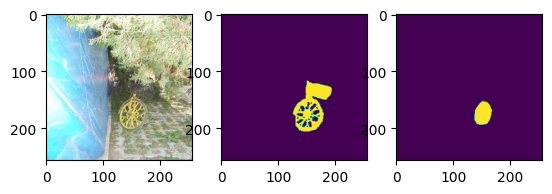

In [23]:
import random
idx = random.randint(0,100)
def visualization_pascalvoc(model, idx):
    model.eval()
    with torch.no_grad():
        x, y = test_dataset.__getitem__(idx) # get x: (C, H , W) , y: (H, W)
#         print(x.shape ,y.shape) # (C, H , W) - > (B, C, H, W) -> model
        x = x.to(device).float().unsqueeze(0) # convert x: (C, H , W) -> (1, C, H, W) vi model need Batch at first
        y = y.to(device).long().unsqueeze(0) # convert x: (C, H , W) -> (1, C, H, W) vi model need Batch at first
        print(y.shape)
        yhat = model(x, y) # input x: (1, C, H, W) and output y: (1, C, H , W)
        print(yhat.shape)
        yhat_mask = yhat.argmax(dim=1) # convert (1, C, H , W) -> (C, H , W)
        print(yhat_mask.shape)
        inv_img_tensor = inverse_norm(x.squeeze()) # x: (1, C, H, W) -> (C, H, W)
        color_mask_prediction = np.zeros((*yhat_mask.shape,3))
        for i, color in enumerate(VOC_COLORMAP):
            color_mask_prediction[yhat_mask.cpu()==i] = np.array(color) # pixel 10(class10) -> [64, 128, 0]
        
        color_mask_true = np.zeros((*yhat.shape,3))
        for i, color in enumerate(VOC_COLORMAP):
            color_mask_true[yhat.cpu()==i] = np.array(color) # pixel 10(class10) -> [64, 128, 0]
        # draw, x, y, yhat_mask
        plt.subplot(1,3,1)
        plt.imshow(inv_img_tensor.permute(1,2,0).cpu())
        plt.subplot(1,3,2)
        plt.imshow(y.squeeze().cpu())
        plt.subplot(1,3,3)
        plt.imshow(yhat_mask.cpu().permute(1,2,0))
        plt.show()
        
visualization_pascalvoc(model, idx)